In [ ]:
#install dependencies
!pip install -q opencv-python-headless scipy scikit-learn tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#paths
DATA_ROOT = "/content/drive/MyDrive/ShanghaiTech"

PART = "part_A"      # change to part_A if needed

IMG_DIR = f"{DATA_ROOT}/{PART}/train_data/images"
GT_DIR  = f"{DATA_ROOT}/{PART}/train_data/ground-truth"

print("Image path:", IMG_DIR)
print("GT path:", GT_DIR)

Image path: /content/drive/MyDrive/ShanghaiTech/part_A/train_data/images
GT path: /content/drive/MyDrive/ShanghaiTech/part_A/train_data/ground-truth


In [ ]:
#preprocessed folder
import os

SAVE_IMG = f"{IMG_DIR}/images_prepro"
os.makedirs(SAVE_IMG, exist_ok=True)

SAVE_GT  = f"{GT_DIR}/ground_truth_prepro"
os.makedirs(SAVE_GT, exist_ok=True)

print("Saving preprocessed files to:", SAVE_IMG)

Saving preprocessed files to: /content/drive/MyDrive/ShanghaiTech/part_A/train_data/images/images_prepro


In [ ]:
import cv2
import numpy as np
import torch
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from tqdm import tqdm

mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

def preprocess_all():
    for img_name in tqdm(os.listdir(IMG_DIR)):
        if not img_name.endswith(".jpg"):
            continue

        # ----- Load Image -----
        img_path = os.path.join(IMG_DIR, img_name)
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        img = img / 255.0

        img_norm = (img - mean) / std

        # ----- Load GT -----
        gt_path = os.path.join(GT_DIR, "GT_" + img_name.replace(".jpg", ".mat"))
        mat = loadmat(gt_path)
        points = mat["image_info"][0][0][0][0][0]

        density = np.zeros((img.shape[0], img.shape[1]), dtype=np.float32)
        for x, y in points:
            x = min(int(x), img.shape[1] - 1)
            y = min(int(y), img.shape[0] - 1)
            density[y, x] = 1

        density = gaussian_filter(density, sigma=2)

        # ----- Downsample 8x -----
        h8, w8 = img.shape[0] // 8, img.shape[1] // 8
        density_8 = cv2.resize(density, (w8, h8), interpolation=cv2.INTER_CUBIC)
        density_8 *= 64

        img_tensor = torch.from_numpy(img_norm).permute(2, 0, 1)
        gt_tensor  = torch.from_numpy(density_8).unsqueeze(0)

        save_path = os.path.join(SAVE_IMG, img_name.replace(".jpg", ".pt"))
        torch.save({"image": img_tensor, "gt": gt_tensor}, save_path)

preprocess_all()
print("✔ Preprocessing Completed!")

100%|██████████| 301/301 [06:17<00:00,  1.26s/it]

✔ Preprocessing Completed!


In [ ]:
#load dataset for training
from torch.utils.data import Dataset, DataLoader

class CrowdDataset(Dataset):
    def __init__(self, path):
        self.files = sorted([f for f in os.listdir(path) if f.endswith(".pt")])
        self.path = path

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = torch.load(os.path.join(self.path, self.files[idx]))
        return data["image"].float(), data["gt"].float()

DATASET = CrowdDataset(SAVE_IMG)
DATALOADER = DataLoader(DATASET, batch_size=2, shuffle=True)

print("Total preprocessed samples:", len(DATASET))

Total preprocessed samples: 300


In [ ]:
#load CSRNet model
import torch.nn as nn
from torchvision import models

class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()
        vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)

        self.frontend = nn.Sequential(*list(vgg.features.children())[:33])

        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv2d(128, 64,  3, padding=2, dilation=2), nn.ReLU(),
        )

        self.output = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CSRNet().to(device)
print("Model loaded on:", device)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


100%|██████████| 528M/528M [00:03<00:00, 151MB/s]


Model loaded on: cuda


In [ ]:
#loss & optimizer
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
import cv2
import numpy as np
import torch
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from tqdm import tqdm

RESIZE_TO = (512, 512)     # <-- FIX HERE

mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

def preprocess_all():
    for img_name in tqdm(os.listdir(IMG_DIR)):
        if not img_name.endswith(".jpg"):
            continue

        # ------------------ LOAD IMAGE ------------------
        img_path = os.path.join(IMG_DIR, img_name)
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB) / 255.0

        H_original, W_original = img.shape[:2]

        # ------------------ LOAD GT ---------------------
        gt_path = os.path.join(GT_DIR, "GT_" + img_name.replace(".jpg", ".mat"))
        mat = loadmat(gt_path)
        points = mat["image_info"][0][0][0][0][0]

        # ------------------ RESIZE IMAGE ----------------
        img_resized = cv2.resize(img, RESIZE_TO)

        # ------------------ SCALE ANNOTATION POINTS ----
        scale_x = RESIZE_TO[0] / W_original
        scale_y = RESIZE_TO[1] / H_original

        scaled_points = []
        for x, y in points:
            new_x = int(x * scale_x)
            new_y = int(y * scale_y)
            scaled_points.append([new_x, new_y])

        # ------------------ GET DENSITY MAP -------------
        density = np.zeros(RESIZE_TO, dtype=np.float32)
        for x, y in scaled_points:
            if x < RESIZE_TO[0] and y < RESIZE_TO[1]:
                density[y, x] = 1

        density = gaussian_filter(density, sigma=3)

        # ------------------ DOWNSAMPLE BY 8x ------------
        h8, w8 = RESIZE_TO[0] // 8, RESIZE_TO[1] // 8
        density_8 = cv2.resize(density, (w8, h8), interpolation=cv2.INTER_CUBIC)
        density_8 *= 64

        # ------------------ NORMALIZE -------------------
        img_norm = (img_resized - mean) / std

        # ------------------ SAVE .pt FILE ---------------
        img_tensor = torch.from_numpy(img_norm).permute(2, 0, 1)
        gt_tensor  = torch.from_numpy(density_8).unsqueeze(0)

        torch.save(
            {"image": img_tensor, "gt": gt_tensor},
            os.path.join(SAVE_IMG, img_name.replace(".jpg", ".pt"))
        )

print("Running preprocessing with resizing to 512x512...")
preprocess_all()
print("✔ Preprocessing Completed")


Running preprocessing with resizing to 512x512...


100%|██████████| 301/301 [00:24<00:00, 12.36it/s]

✔ Preprocessing Completed


In [ ]:
import os

print("Total .pt preprocessed files:", len(os.listdir(SAVE_IMG)))
print(os.listdir(SAVE_IMG)[:5])

Total .pt preprocessed files: 300
['IMG_111.pt', 'IMG_136.pt', 'IMG_125.pt', 'IMG_135.pt', 'IMG_10.pt']


In [ ]:
from torch.utils.data import Dataset, DataLoader

class CrowdDataset(Dataset):
    def __init__(self, path):
        self.files = sorted([f for f in os.listdir(path) if f.endswith(".pt")])
        self.path = path

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = torch.load(os.path.join(self.path, self.files[idx]))
        return data["image"].float(), data["gt"].float()

dataset = CrowdDataset(SAVE_IMG)
DATALOADER = DataLoader(dataset, batch_size=4, shuffle=True)

print("Dataset ready:", len(dataset))

Dataset ready: 300


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()

        vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:33])

        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv2d(128, 64,  3, padding=2, dilation=2), nn.ReLU(),
        )

        self.output = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CSRNet().to(device)

print("Model loaded on:", device)

Model loaded on: cuda


In [ ]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
#training
from tqdm import tqdm

epochs = 20            # start with 20
epoch_losses = []

for ep in range(epochs):
    model.train()
    total_loss = 0

    print(f"\n🔵 EPOCH {ep+1}/{epochs}")

    for img, gt in tqdm(DATALOADER, desc=f"Epoch {ep+1}", ncols=100):
        img, gt = img.to(device), gt.to(device)

        pred = model(img)
        loss = criterion(pred, gt)

        if torch.isnan(loss):
            continue

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(DATALOADER)
    epoch_losses.append(avg_loss)
    print(f"✅ Epoch {ep+1} Loss = {avg_loss:.6f}")


🔵 EPOCH 1/20


Epoch 1: 100%|██████████████████████████████████████████████████████| 75/75 [00:45<00:00,  1.65it/s]


✅ Epoch 1 Loss = 0.149092

🔵 EPOCH 2/20


Epoch 2: 100%|██████████████████████████████████████████████████████| 75/75 [00:44<00:00,  1.67it/s]


✅ Epoch 2 Loss = 0.105836

🔵 EPOCH 3/20


Epoch 3: 100%|██████████████████████████████████████████████████████| 75/75 [00:45<00:00,  1.63it/s]


✅ Epoch 3 Loss = 0.100101

🔵 EPOCH 4/20


Epoch 4: 100%|██████████████████████████████████████████████████████| 75/75 [00:45<00:00,  1.64it/s]


✅ Epoch 4 Loss = 0.093868

🔵 EPOCH 5/20


Epoch 5: 100%|██████████████████████████████████████████████████████| 75/75 [00:45<00:00,  1.63it/s]


✅ Epoch 5 Loss = 0.088250

🔵 EPOCH 6/20


Epoch 6: 100%|██████████████████████████████████████████████████████| 75/75 [00:45<00:00,  1.63it/s]


✅ Epoch 6 Loss = 0.085372

🔵 EPOCH 7/20


Epoch 7: 100%|██████████████████████████████████████████████████████| 75/75 [00:45<00:00,  1.63it/s]


✅ Epoch 7 Loss = 0.081055

🔵 EPOCH 8/20


Epoch 8: 100%|██████████████████████████████████████████████████████| 75/75 [00:45<00:00,  1.63it/s]


✅ Epoch 8 Loss = 0.078827

🔵 EPOCH 9/20


Epoch 9: 100%|██████████████████████████████████████████████████████| 75/75 [00:45<00:00,  1.63it/s]


✅ Epoch 9 Loss = 0.076081

🔵 EPOCH 10/20


Epoch 10: 100%|█████████████████████████████████████████████████████| 75/75 [00:46<00:00,  1.63it/s]


✅ Epoch 10 Loss = 0.074555

🔵 EPOCH 11/20


Epoch 11: 100%|█████████████████████████████████████████████████████| 75/75 [00:46<00:00,  1.63it/s]


✅ Epoch 11 Loss = 0.079195

🔵 EPOCH 12/20


Epoch 12: 100%|█████████████████████████████████████████████████████| 75/75 [00:45<00:00,  1.63it/s]


✅ Epoch 12 Loss = 0.075218

🔵 EPOCH 13/20


Epoch 13: 100%|█████████████████████████████████████████████████████| 75/75 [00:45<00:00,  1.63it/s]


✅ Epoch 13 Loss = 0.074633

🔵 EPOCH 14/20


Epoch 14: 100%|█████████████████████████████████████████████████████| 75/75 [00:45<00:00,  1.63it/s]


✅ Epoch 14 Loss = 0.068510

🔵 EPOCH 15/20


Epoch 15: 100%|█████████████████████████████████████████████████████| 75/75 [00:46<00:00,  1.63it/s]


✅ Epoch 15 Loss = 0.066839

🔵 EPOCH 16/20


Epoch 16: 100%|█████████████████████████████████████████████████████| 75/75 [00:46<00:00,  1.63it/s]


✅ Epoch 16 Loss = 0.068424

🔵 EPOCH 17/20


Epoch 17: 100%|█████████████████████████████████████████████████████| 75/75 [00:45<00:00,  1.64it/s]


✅ Epoch 17 Loss = 0.067401

🔵 EPOCH 18/20


Epoch 18: 100%|█████████████████████████████████████████████████████| 75/75 [00:45<00:00,  1.63it/s]


✅ Epoch 18 Loss = 0.066090

🔵 EPOCH 19/20


Epoch 19: 100%|█████████████████████████████████████████████████████| 75/75 [00:45<00:00,  1.63it/s]


✅ Epoch 19 Loss = 0.064842

🔵 EPOCH 20/20


Epoch 20: 100%|█████████████████████████████████████████████████████| 75/75 [00:46<00:00,  1.63it/s]

✅ Epoch 20 Loss = 0.064289


In [ ]:
torch.save(model.state_dict(), "/content/csrnet_partA_weights.pth")
print("Model saved as csrnet_partA_weights.pth")

Model saved as csrnet_partA_weights.pth


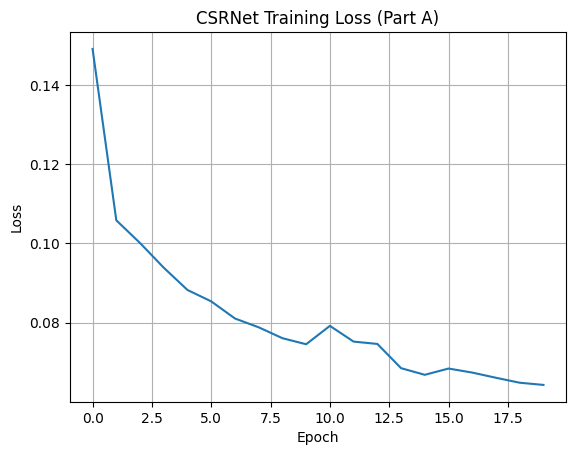

In [ ]:
#plot training loss
import matplotlib.pyplot as plt

plt.plot(epoch_losses)
plt.title("CSRNet Training Loss (Part A)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [ ]:
#create validation split (20%)
from sklearn.model_selection import train_test_split

all_files = sorted([f for f in os.listdir(SAVE_IMG) if f.endswith(".pt")])

train_files, val_files = train_test_split(
    all_files, test_size=0.2, random_state=42
)

print("Training samples:", len(train_files))
print("Validation samples:", len(val_files))

Training samples: 240
Validation samples: 60


In [ ]:
#create train & validation datasets
class CrowdDatasetSplit(Dataset):
    def __init__(self, file_list, folder):
        self.files = file_list
        self.folder = folder

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = torch.load(os.path.join(self.folder, self.files[idx]))
        return data["image"].float(), data["gt"].float()

In [ ]:
#build dataloaders
train_loader = DataLoader(
    CrowdDatasetSplit(train_files, SAVE_IMG),
    batch_size=4,
    shuffle=True
)

val_loader = DataLoader(
    CrowdDatasetSplit(val_files, SAVE_IMG),
    batch_size=1,       # IMPORTANT: count estimation must run batch size 1
    shuffle=False
)

print("Train:", len(train_loader), "batches")
print("Val:", len(val_loader), "batches")

Train: 60 batches
Val: 60 batches


In [ ]:
#validation function (MAE/RMSE)
import numpy as np
from math import sqrt

def validate(model, dataloader):
    model.eval()
    mae = 0.0
    mse = 0.0

    with torch.no_grad():
        for img, gt in dataloader:
            img = img.to(device)
            gt = gt.to(device)

            pred = model(img)

            # Count = sum of density map
            pred_count = pred.sum().item()
            true_count = gt.sum().item()

            mae += abs(pred_count - true_count)
            mse += (pred_count - true_count) ** 2

    mae /= len(dataloader)
    rmse = sqrt(mse / len(dataloader))

    return mae, rmse

In [ ]:
#training loop with validation
epochs = 20
epoch_losses = []
val_mae_list = []
val_rmse_list = []

for ep in range(epochs):
    model.train()
    total_loss = 0

    print(f"\n🔵 EPOCH {ep+1}/{epochs}")

    # ---------- TRAINING ----------
    for img, gt in tqdm(train_loader, desc=f"Train {ep+1}", ncols=100):
        img, gt = img.to(device), gt.to(device)

        pred = model(img)
        loss = criterion(pred, gt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)

    print(f"🟢 Training Loss = {avg_loss:.4f}")

    # ---------- VALIDATION ----------
    mae, rmse = validate(model, val_loader)
    val_mae_list.append(mae)
    val_rmse_list.append(rmse)

    print(f"🔴 Validation MAE  = {mae:.2f}")
    print(f"🔴 Validation RMSE = {rmse:.2f}")


🔵 EPOCH 1/20


Train 1: 100%|██████████████████████████████████████████████████████| 60/60 [00:37<00:00,  1.59it/s]


🟢 Training Loss = 0.0647
🔴 Validation MAE  = 72.88
🔴 Validation RMSE = 121.77

🔵 EPOCH 2/20


Train 2: 100%|██████████████████████████████████████████████████████| 60/60 [00:36<00:00,  1.63it/s]


🟢 Training Loss = 0.0650
🔴 Validation MAE  = 76.90
🔴 Validation RMSE = 117.95

🔵 EPOCH 3/20


Train 3: 100%|██████████████████████████████████████████████████████| 60/60 [00:36<00:00,  1.63it/s]


🟢 Training Loss = 0.0648
🔴 Validation MAE  = 76.66
🔴 Validation RMSE = 126.01

🔵 EPOCH 4/20


Train 4: 100%|██████████████████████████████████████████████████████| 60/60 [00:36<00:00,  1.63it/s]


🟢 Training Loss = 0.0644
🔴 Validation MAE  = 71.27
🔴 Validation RMSE = 110.97

🔵 EPOCH 5/20


Train 5: 100%|██████████████████████████████████████████████████████| 60/60 [00:36<00:00,  1.63it/s]


🟢 Training Loss = 0.0644
🔴 Validation MAE  = 68.43
🔴 Validation RMSE = 101.91

🔵 EPOCH 6/20


Train 6: 100%|██████████████████████████████████████████████████████| 60/60 [00:36<00:00,  1.63it/s]


🟢 Training Loss = 0.0629
🔴 Validation MAE  = 84.35
🔴 Validation RMSE = 145.28

🔵 EPOCH 7/20


Train 7: 100%|██████████████████████████████████████████████████████| 60/60 [00:36<00:00,  1.63it/s]


🟢 Training Loss = 0.0629
🔴 Validation MAE  = 111.46
🔴 Validation RMSE = 192.54

🔵 EPOCH 8/20


Train 8: 100%|██████████████████████████████████████████████████████| 60/60 [00:36<00:00,  1.63it/s]


🟢 Training Loss = 0.0618
🔴 Validation MAE  = 88.06
🔴 Validation RMSE = 133.82

🔵 EPOCH 9/20


Train 9: 100%|██████████████████████████████████████████████████████| 60/60 [00:36<00:00,  1.63it/s]


🟢 Training Loss = 0.0605
🔴 Validation MAE  = 89.42
🔴 Validation RMSE = 141.31

🔵 EPOCH 10/20


Train 10: 100%|█████████████████████████████████████████████████████| 60/60 [00:36<00:00,  1.63it/s]


🟢 Training Loss = 0.0604
🔴 Validation MAE  = 69.86
🔴 Validation RMSE = 104.43

🔵 EPOCH 11/20


Train 11: 100%|█████████████████████████████████████████████████████| 60/60 [00:36<00:00,  1.63it/s]


🟢 Training Loss = 0.0614
🔴 Validation MAE  = 87.33
🔴 Validation RMSE = 140.91

🔵 EPOCH 12/20


Train 12: 100%|█████████████████████████████████████████████████████| 60/60 [00:36<00:00,  1.63it/s]


🟢 Training Loss = 0.0595
🔴 Validation MAE  = 65.87
🔴 Validation RMSE = 106.44

🔵 EPOCH 13/20


Train 13: 100%|█████████████████████████████████████████████████████| 60/60 [00:38<00:00,  1.56it/s]


🟢 Training Loss = 0.0585
🔴 Validation MAE  = 77.87
🔴 Validation RMSE = 115.82

🔵 EPOCH 14/20


Train 14: 100%|█████████████████████████████████████████████████████| 60/60 [00:36<00:00,  1.63it/s]


🟢 Training Loss = 0.0578
🔴 Validation MAE  = 86.55
🔴 Validation RMSE = 147.56

🔵 EPOCH 15/20


Train 15: 100%|█████████████████████████████████████████████████████| 60/60 [00:36<00:00,  1.63it/s]


🟢 Training Loss = 0.0594
🔴 Validation MAE  = 68.87
🔴 Validation RMSE = 90.81

🔵 EPOCH 16/20


Train 16: 100%|█████████████████████████████████████████████████████| 60/60 [00:36<00:00,  1.63it/s]


🟢 Training Loss = 0.0580
🔴 Validation MAE  = 101.00
🔴 Validation RMSE = 158.18

🔵 EPOCH 17/20


Train 17: 100%|█████████████████████████████████████████████████████| 60/60 [00:36<00:00,  1.63it/s]


🟢 Training Loss = 0.0582
🔴 Validation MAE  = 85.64
🔴 Validation RMSE = 137.43

🔵 EPOCH 18/20


Train 18: 100%|█████████████████████████████████████████████████████| 60/60 [00:36<00:00,  1.63it/s]


🟢 Training Loss = 0.0570
🔴 Validation MAE  = 62.58
🔴 Validation RMSE = 86.95

🔵 EPOCH 19/20


Train 19: 100%|█████████████████████████████████████████████████████| 60/60 [00:36<00:00,  1.63it/s]


🟢 Training Loss = 0.0570
🔴 Validation MAE  = 89.44
🔴 Validation RMSE = 122.34

🔵 EPOCH 20/20


Train 20: 100%|█████████████████████████████████████████████████████| 60/60 [00:36<00:00,  1.63it/s]


🟢 Training Loss = 0.0569
🔴 Validation MAE  = 65.81
🔴 Validation RMSE = 110.78


In [ ]:
best_mae = float("inf")
best_path = "/content/best_csrnet_partA.pth"

if mae < best_mae:
    best_mae = mae
    torch.save(model.state_dict(), best_path)
    print("New Best Model Saved!")

New Best Model Saved!


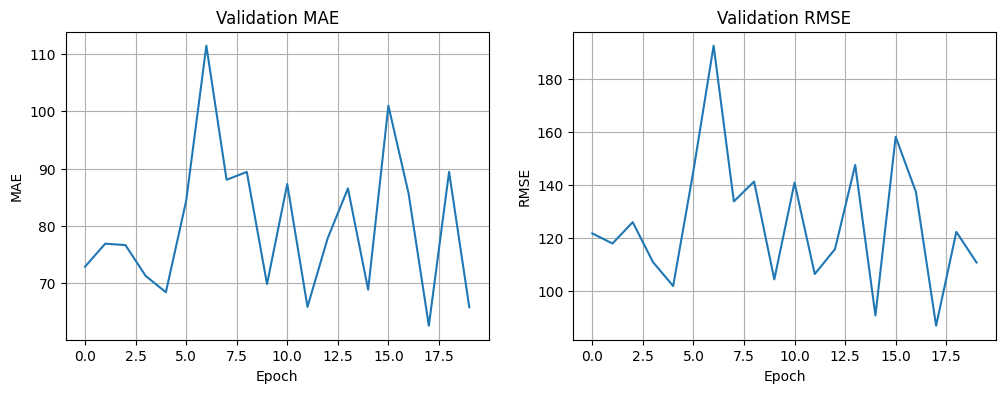

In [ ]:
#plot MAE & RMSE curves
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(val_mae_list, label="MAE")
plt.title("Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(val_rmse_list, label="RMSE")
plt.title("Validation RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(True)

plt.show()